System of ODE Model

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import ode
import os 
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
from tqdm import trange
from matplotlib import cycler
import math

sns.set(style='whitegrid')

plt.rcParams['font.family']='serif'
plt.rcParams['font.serif']=['Times New Roman']+plt.rcParams['font.serif']
plt.rcParams['figure.figsize']=[16,9]
mpl.rcParams['figure.dpi']=300
mpl.rcParams['axes.unicode_minus'] = False


colors = cycler('color',['#003e8f','#d69160','#4682B4','#ffc20e','#FF6347','#00ae9d','#9932CC'])
plt.rc('axes', prop_cycle=colors)

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
%config InlineBackend.figure_format = 'retina'

In [2]:
data = pd.read_excel('LA_and_LA_adjacent_commuting_data.xlsx') 
counties = data['Home County'].unique() 
countiesdf = pd.DataFrame(counties)
dfCountyPop = pd.DataFrame( {
"Populations": [1682353, 1204, 40474, 211632, 45292, 21839, 1165927, 27743, 191185, 1008654, 28917, 136463, 179702, 19016, 909235, 152486, 68163, 32730, 10014009, 156255, 262321, 17131, 91601, 281202, 8700, 13195, 439035, 138019, 102241, 3186989, 404739, 19790, 2418185, 1585055, 64209, 2181654, 3298634, 873965, 779233, 282424, 764442, 448229, 1936259, 270861, 182155, 3236, 44076, 453491, 488863, 552878, 99633, 65829, 16112, 473117, 55620, 843843, 216403, 81575], } )
mergedDf = pd.concat([countiesdf, dfCountyPop], axis = 1)
mergedDf.columns = ["County", "Populations"]
print(mergedDf)
print(data)
print(data["Commuters"])
data2 = data

                    County  Populations
0           Alameda County      1682353
1            Alpine County         1204
2            Amador County        40474
3             Butte County       211632
4         Calaveras County        45292
5            Colusa County        21839
6      Contra Costa County      1165927
7         Del Norte County        27743
8         El Dorado County       191185
9            Fresno County      1008654
10            Glenn County        28917
11         Humboldt County       136463
12         Imperial County       179702
13             Inyo County        19016
14             Kern County       909235
15            Kings County       152486
16             Lake County        68163
17           Lassen County        32730
18      Los Angeles County     10014009
19           Madera County       156255
20            Marin County       262321
21         Mariposa County        17131
22        Mendocino County        91601
23           Merced County       281202


Create commuting data a percentage based on county populations

In [3]:
for index, row in data2.iterrows():
    i = 0
    for rows in mergedDf["County"]:
        if row["Home County"] == rows:
            data2["Commuters"][index] = row["Commuters"] / mergedDf.loc[i].iat[1]
            break
        i += 1
        
print(data2)
data.to_excel('commuterPercentage.xlsx')

/var/folders/hv/11_5045n7_z_h35cmdkbvdn40000gn/T/ipykernel_2891/922982090.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2["Commuters"][index] = row["Commuters"] / mergedDf.loc[i].iat[1]


         Home County     Workplace County  Commuters
0     Alameda County       Alameda County   0.274776
1     Alameda County  Contra Costa County   0.024377
2     Alameda County     El Dorado County   0.000007
3     Alameda County        Fresno County   0.000058
4     Alameda County      Humboldt County   0.000036
...              ...                  ...        ...
1692     Yuba County        Solano County   0.001103
1693     Yuba County    Stanislaus County   0.000282
1694     Yuba County        Sutter County   0.058878
1695     Yuba County          Yolo County   0.007784
1696     Yuba County          Yuba County   0.153393

[1697 rows x 3 columns]


Create commuting matrix

In [4]:
linearMap = pd.DataFrame(columns=mergedDf["County"],index=mergedDf["County"])
i = 0
for index, row in linearMap.iterrows():
    for rows in mergedDf["County"]:
        for indexCommute, rowCommute in data.iterrows():
            if (rowCommute["Home County"] == index) & (rowCommute["Workplace County"] == rows):
                linearMap[index][rows] = data["Commuters"][i]
                i += 1
                print(i)
                break
linearMap = linearMap.fillna(0)
print(linearMap)
CommutingArray = linearMap.to_numpy()
print(CommutingArray)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


Create initial data

In [6]:
covidCases = pd.read_excel('Covid Data.xlsx') 
covidArray = covidCases['cases'][0:58].tolist()
print(covidArray)

population = [1682353, 1204, 40474, 211632, 45292, 21839, 1165927, 27743, 191185, 1008654, 28917, 136463, 179702, 19016, 909235, 152486, 68163, 32730, 10014009, 156255, 262321, 17131, 91601, 281202, 8700, 13195, 439035, 138019, 102241, 3186989, 404739, 19790, 2418185, 1585055, 64209, 2181654, 3298634, 873965, 779233, 282424, 764442, 448229, 1936259, 270861, 182155, 3236, 44076, 453491, 488863, 552878, 99633, 65829, 16112, 473117, 55620, 843843, 216403, 81575]
y0 = []
for k in range(116):
    if k % 2 == 0:
        sub = population[int(k/2)] - covidArray[int(k/2)]
        y0.append(sub)
    elif k % 2 == 1:
        y0.append(covidArray[int((k-1)/2)])
y0

[3, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 2, 1, 1, 2, 0, 0, 0, 1, 2, 4, 1, 3, 6, 4, 6, 2, 5, 25, 28, 21, 30, 25, 19, 19, 47, 29, 32, 29, 36, 21, 24, 39, 32, 32, 21, 40, 19, 27]


[1682350,
 3,
 1204,
 0,
 40474,
 0,
 211632,
 0,
 45292,
 0,
 21838,
 1,
 1165927,
 0,
 27743,
 0,
 191184,
 1,
 1008654,
 0,
 28917,
 0,
 136463,
 0,
 179702,
 0,
 19016,
 0,
 909234,
 1,
 152486,
 0,
 68162,
 1,
 32730,
 0,
 10014009,
 0,
 156254,
 1,
 262319,
 2,
 17130,
 1,
 91600,
 1,
 281200,
 2,
 8700,
 0,
 13195,
 0,
 439035,
 0,
 138018,
 1,
 102239,
 2,
 3186985,
 4,
 404738,
 1,
 19787,
 3,
 2418179,
 6,
 1585051,
 4,
 64203,
 6,
 2181652,
 2,
 3298629,
 5,
 873940,
 25,
 779205,
 28,
 282403,
 21,
 764412,
 30,
 448204,
 25,
 1936240,
 19,
 270842,
 19,
 182108,
 47,
 3207,
 29,
 44044,
 32,
 453462,
 29,
 488827,
 36,
 552857,
 21,
 99609,
 24,
 65790,
 39,
 16080,
 32,
 473085,
 32,
 55599,
 21,
 843803,
 40,
 216384,
 19,
 81548,
 27]

Create SI-Model


In [8]:
def model(y, t):

    population = [1682353, 1204, 40474, 211632, 45292, 21839, 1165927, 27743, 191185, 1008654, 28917, 136463, 179702, 19016, 909235, 152486, 68163, 32730, 10014009, 156255, 262321, 17131, 91601, 281202, 8700, 13195, 439035, 138019, 102241, 3186989, 404739, 19790, 2418185, 1585055, 64209, 2181654, 3298634, 873965, 779233, 282424, 764442, 448229, 1936259, 270861, 182155, 3236, 44076, 453491, 488863, 552878, 99633, 65829, 16112, 473117, 55620, 843843, 216403, 81575]
    dydt = np.zeros(116)
    for k in range(116):
        if k % 2 == 0:  
            for i in range(58):
                f = int(k/2)
                dydt[k] -= beta*y[f]*CommutingArray[f,i]/population[f]
        elif k % 2 == 1: 
            dydt[k] = -1*dydt[k-1]
                             
    return dydt

Find the infection rate that minimizes the mean squared error

In [9]:
betaList = np.linspace(0, 2, 200)
bestBeta = 0
bestError = 1000000
t = np.linspace(0,14,14)
confirmed2Weeks = covidCases['cases'][754:815].tolist()
for beta in betaList:

# solve ODE
    ysol = odeint(model,y0,t)
#calculate MSE
    error = 0
    for i in range(58):
        error += (confirmed2Weeks[i]-ysol[13,2*i+1])**2
    error = math.sqrt(error)/58
    if error < bestError:
        bestError = error
        bestBeta = beta
print(bestError)
print(bestBeta)

23.37924049442134
2.0


Redo the model using the best beta and plot SI curves for each region

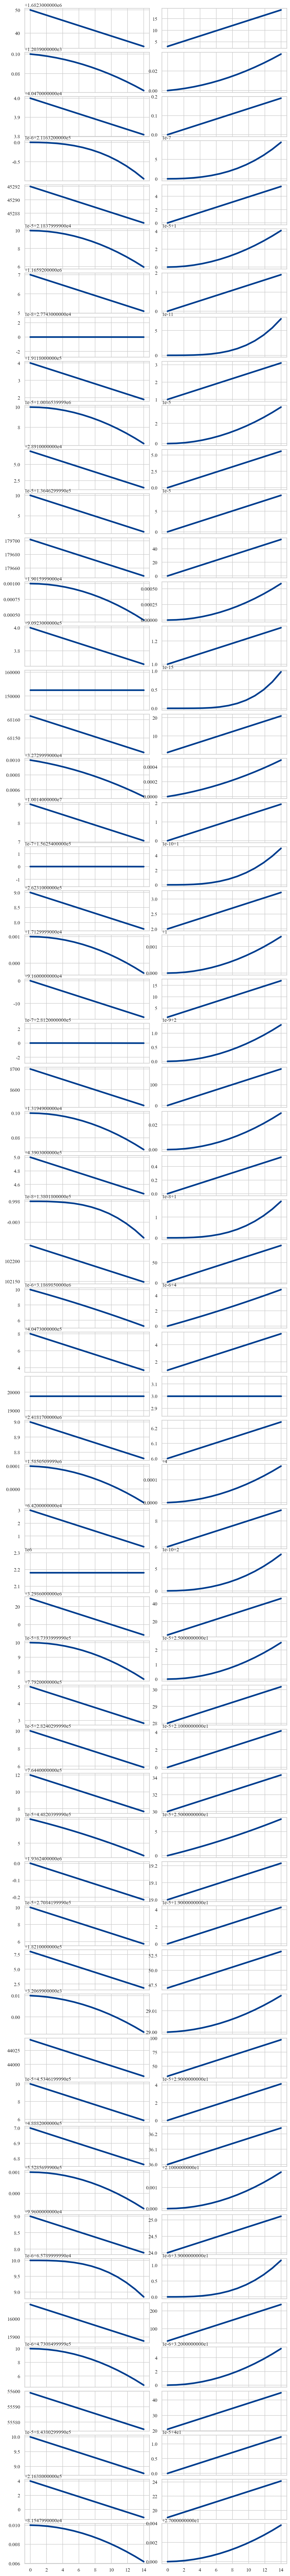

In [10]:
fig,ax = plt.subplots(ncols = 2,nrows = 58,figsize = [10,100])
fig.subplots_adjust(wspace=0.1, hspace=0.1)

beta = bestBeta
# solve ODE
ysol = odeint(model,y0,t)

for i in range(58):
    ax[i,0].plot(t,ysol[:,2*i],linewidth=3.5)
    ax[i,1].plot(t,ysol[:,2*i+1],linewidth=3.5)